In [95]:
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

%config InlineBackend.figure_format = 'svg'
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.weight'] = 'ultralight'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 14
plt.rcParams['font.style'] = 'normal'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['mathtext.fontset'] = 'stix'

In [48]:
# Исходные данные для выполнения ДЗ

class SiStructure:
    def __init__(self, a, b, n, omega, Ex_x, Nb, V = 0) -> None:
        """Структура, содержащая характеристики боевой единицы

        Атрибуты
        ----------
        a : float
            Размер a
        b : float
            Размер b
        n : float
            Скорострельность, 1/мин
        omega : float
            Среднее число попаданий, необходимое для поражения целей
        Ex_x : float
            Характеристики рассеивания
        Nb : float
            Боекомплект: САУ100 = 40, САУ152 = 30, танк = 40, ПТУР = 2
        V : float
            Скорость передвижения, м/с

        Методы
        ------

        W(a,b,x) -> float
            Вероятность выхода из строя
        """
        self.a = a              # Размер a
        self.b = b              # Размер b
        self.n = n              # Скорострельность, 1/мин
        self.omega = omega      # Среднее число попаданий, необходимое для поражения целей
        self.Ex_x = Ex_x        # Характеристики рассеивания
        self.Nb = Nb
        self.V = V

    def F_x(self, x):
        return norm.cdf(x) - 0.5
    
    def sigma(self,x):
        return 1.48 * self.Ex_x * x

    def W(self,a,b,x):
        """Вероятность выхода из строя

        Параметры
        ----------
        a : float
            Размер a противника
        b : float
            Размер b противника
        x : float
            Расстояние до противника

        Returns
        -------
        float
            Вероятность выхода из строя
        """
        _sigma = self.sigma(x)
        P = 4 * self.F_x((b/2) / _sigma) * self.F_x((a/2) / _sigma)
        return P / self.omega

# данные из методы    
# tank = SiStructure(2.2, 3.0, 14, 1.3, 1/1200, 40, 14)
# sau100 = SiStructure(1.5, 2.0, 12, 1.6, 1/800, 40)
# sau152 = SiStructure(1.5, 2.0, 12, 1.1, 1/900, 30)
# ptur = SiStructure(1.5, 2.0, 0, 1.0, 1/800, 2, 120)
# x0 = 900 # Начальное расстояние

# данные Максимки
tank = SiStructure(2.8, 2.0, 10, 1.4, 1/1400, 40, 13)
sau100 = SiStructure(1.9, 2.1, 10, 1.6, 1/1200, 40)
sau152 = SiStructure(1.9, 2.1, 10, 1.3, 1/800, 30)
ptur = SiStructure(1.9, 2.1, 0, 1.1, 1/1600, 2, 170)


x0 = 1800 # Начальное расстояние
t0 = 4 # Время, спустя которое в работу включается Т
ptur_type = 'ком' # Тип ПТРК

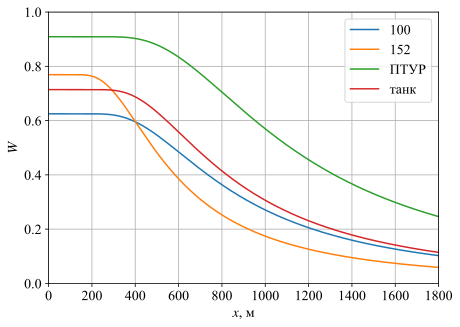

In [49]:
# Графики зависимости вероятности поражения от расстояния

xs = np.linspace(0.01, 2000, 1000)

Ws_tank = []
Ws_sau100 = []
Ws_sau152 = []
Ws_ptur = []

for x in xs:
    Ws_tank.append(tank.W(sau100.a, sau100.b, x))
    Ws_sau100.append(sau100.W(tank.a, tank.b, x))
    Ws_sau152.append(sau152.W(tank.a, tank.b, x))
    Ws_ptur.append(ptur.W(tank.a, tank.b, x))

plt.figure(figsize=(7,5))
plt.plot(xs, Ws_sau100, label='$100$')
plt.plot(xs, Ws_sau152, label='$152$')
plt.plot(xs, Ws_ptur, label='$ПТУР$')
plt.plot(xs, Ws_tank, label='$танк$')

plt.xlim(0,x0)
plt.ylim(0,1)

plt.xlabel('$\mathit{x}$, м')
plt.ylabel('$\mathit{W}$')

plt.legend()
plt.grid()
plt.show()

In [51]:
# Таблица W(P)
x_df=np.linspace(x0,1e-9, round(x0/100) + 1) # Массив значений расстояний

df = pd.DataFrame({
    'sigma_100': [sau100.sigma(x) for x in x_df],
    'sigma_152': [sau152.sigma(x) for x in x_df],
    'sigma_tank': [tank.sigma(x) for x in x_df],
    'Fa_100': [sau100.F_x(tank.a / 2 / sau100.sigma(x)) for x in x_df],
    'Fb_100': [sau100.F_x(tank.b / 2 / sau100.sigma(x)) for x in x_df],
    'Fa_152': [sau152.F_x(tank.a / 2 / sau152.sigma(x)) for x in x_df],
    'Fb_152': [sau152.F_x(tank.b / 2 / sau152.sigma(x)) for x in x_df],
    'Fa_tank': [tank.F_x(sau100.a / 2 / tank.sigma(x)) for x in x_df],
    'Fb_tank': [tank.F_x(sau100.b / 2 / tank.sigma(x)) for x in x_df],
    'W_100': [sau100.W(tank.a, tank.b, x) for x in x_df],
    'W_152': [sau152.W(tank.a, tank.b, x) for x in x_df],
    'W_tank': [tank.W(sau100.a, sau100.b, x) for x in x_df]
}, index = x_df)
df.columns.name = 'x'
df.index = df.index.astype('int')
for key, mod in zip(df.keys(),['{:,.3f}']*12):
    df[key] = df[key].map(mod.format)

display(df)

x,sigma_100,sigma_152,sigma_tank,Fa_100,Fb_100,Fa_152,Fb_152,Fa_tank,Fb_tank,W_100,W_152,W_tank
1800,2.220,3.330,1.903,0.236,0.174,0.163,0.118,0.191,0.209,0.102,0.059,0.114
1700,2.097,3.145,1.797,0.248,0.183,0.172,0.125,0.201,0.220,0.114,0.066,0.127
1600,1.973,2.960,1.691,0.261,0.194,0.182,0.132,0.213,0.233,0.126,0.074,0.141
1500,1.850,2.775,1.586,0.275,0.206,0.193,0.141,0.225,0.246,0.142,0.084,0.158
1400,1.727,2.590,1.480,0.291,0.219,0.206,0.150,0.240,0.261,0.159,0.095,0.179
1300,1.603,2.405,1.374,0.309,0.234,0.220,0.161,0.255,0.278,0.180,0.109,0.202
1200,1.480,2.220,1.269,0.328,0.250,0.236,0.174,0.273,0.296,0.205,0.126,0.231
1100,1.357,2.035,1.163,0.349,0.269,0.254,0.188,0.293,0.317,0.235,0.147,0.265
1000,1.233,1.850,1.057,0.372,0.291,0.275,0.206,0.316,0.340,0.271,0.174,0.306
900,1.110,1.665,0.951,0.396,0.316,0.300,0.226,0.341,0.365,0.313,0.208,0.356


In [90]:
# # Дуэль Т и САУ с 100-мм ПТП
def duel(tank : SiStructure, sau : SiStructure):
    # массив времен
    ts = [0]

    # относительная скорость
    V_otn = sau.V + tank.V

    # расстояние
    x = x0

    # массив кто выстрелил
    who_shot = ['сау']

    # моменты времени выстрелов САУ и танка
    t_sau = 0; t_tank = 4 - 1 / tank.n * 60

    # W и V
    Ws = [sau.W(tank.a, tank.b, x)]; Vs = [0]
    
    # W и V с тильдами
    W_tilds = [Ws[0]]; V_tilds = [0]

    # Израсходованный боезапас
    N_sau = 1; N_tank = 0

    # произведение 1 - W (или 1 - V)
    WV_minus_1 = 1 - Ws[-1]

    crit = True

    while W_tilds[-1] + V_tilds[-1] < 1 and x > 0 and N_tank < tank.Nb and N_sau < sau.Nb and crit:
        # W_tilds[-1] + V_tilds[-1] < 1 - пока их сумма не равна 1
        # x > 0 - пока не встретились
        # N_tank < tank.Nb and N_sau < sau.Nb - пока боекомплект не израсходован
        # crit - пока отклонение прошлого W от нынешенего еще велико

        # время выстрелов
        t_sau += 1 / sau.n * 60
        t_tank += 1 / tank.n * 60
        
        # выстреливает сау
        if t_tank > t_sau:
            ts.append(t_sau) 
            who_shot.append('сау')
            x = x0 - V_otn * ts[-1]
            t_tank -= 1 / tank.n * 60     # возвращаем время танку
            Ws.append(sau.W(tank.a,tank.b,x))
            W_tilds.append(W_tilds[-1] + WV_minus_1 * Ws[-1])
            WV_minus_1 *= 1 - Ws[-1]
            N_sau += 1
        
        # выстреливает танк
        elif t_tank < t_sau:
            ts.append(t_tank)
            who_shot.append('танк')
            x = x0 - V_otn * ts[-1]
            t_sau -= 1 / sau.n * 60   # возвращаем время САУ
            Vs.append(tank.W(sau.a, sau.b, x))
            V_tilds.append(V_tilds[-1] + WV_minus_1 * Vs[-1])
            WV_minus_1 *= 1 - Vs[-1]
            N_tank += 1

        # выстрелили оба
        else:
            ts.append(t_tank)
            who_shot.append('оба')
            x = x0 - V_otn * ts[-1]
            Ws.append(sau.W(tank.a,tank.b,x))
            Vs.append(tank.W(sau.a, sau.b, x))
            W_tilds.append(W_tilds[-1] + WV_minus_1 * Ws[-1] * (1 + (1 - Vs[-1]) / 2))
            V_tilds.append(W_tilds[-1] + WV_minus_1 * Vs[-1] * (1 + (1 - Ws[-1]) / 2))
            WV_minus_1 *= (1 - Ws[-1]) * (1 - Vs[-1])
            N_sau += 1
            N_tank += 1

        if len(W_tilds) > 1 and len(V_tilds) > 1:
            crit = abs(W_tilds[-2] - W_tilds[-1]) / W_tilds[-2] > 0.01 or abs(V_tilds[-2] - V_tilds[-1]) / V_tilds[-2] > 0.01

    return {
        't': np.array(ts),
        'who': np.array(who_shot),
        'W_tild': np.array(W_tilds),
        'V_tild': np.array(V_tilds[1:]),
        'N_tank': N_tank,
        'N_sau': N_sau
    }

In [136]:
def cyclogram(res_duel, mm = '', save_name = None):
    
    plt.figure(figsize=(7,2))
    plt.scatter(res_duel['t'][res_duel['who'] == 'танк'],[1]*len(res_duel['V_tild']),marker = '^', zorder = 2)
    plt.scatter(res_duel['t'][res_duel['who'] == 'сау'],[2]*len(res_duel['W_tild']),marker = 'p', color = 'tab:red', zorder = 2)
    plt.yticks([1,2],['Танк 100-мм','САУ' + mm])
    plt.ylim(0.5,2.5)
    plt.grid(zorder = 1)
    plt.xlabel('$\mathit{t}$, с')
    
    if save_name:
        plt.savefig(save_name, dpi=300, bbox_inches='tight')
    
    plt.show()

def dynamic_plot(res_duel, mm = '', save_name = None):

    # интерполяция
    t_sau = res_duel['t'][res_duel['who'] == 'сау']
    Wt_sau = res_duel['W_tild']
    if res_duel['who'][-1] == 'танк':
        t_sau = np.append(t_sau, res_duel['t'][-1])
        Wt_sau = np.append(Wt_sau,res_duel['W_tild'][-1])
    W_sau = interp1d(t_sau,Wt_sau,'cubic')

    t_tank = np.insert(res_duel['t'][res_duel['who'] == 'танк'],0,0)
    Wt_tank = np.insert(res_duel['V_tild'],0,0)
    if res_duel['who'][-1] == 'сау':
        t_tank = np.append(t_tank, res_duel['t'][-1])
        Wt_tank = np.append(Wt_tank,res_duel['V_tild'][-1])
    W_tank = interp1d(t_tank,Wt_tank,'cubic')

    W_nobody = lambda t: 1 - W_sau(t) - W_tank(t)

    ts = np.linspace(0,res_duel['t'][-1],300)

    plt.figure(figsize=(7,5))
    plt.plot(ts,W_tank(ts),label = 'Танк 100-мм',zorder = 2)
    plt.scatter(res_duel['t'][res_duel['who'] == 'танк'],res_duel['V_tild'],edgecolors='tab:blue',facecolor = 'white',zorder = 3)
    plt.plot(ts,W_sau(ts),label = 'САУ' + mm, color = 'tab:red',zorder = 2)
    plt.scatter(res_duel['t'][res_duel['who'] == 'сау'],res_duel['W_tild'],edgecolors='tab:red',facecolor = 'white',zorder = 3)
    plt.plot(ts,W_nobody(ts), label = 'Ничья',color = 'tab:green',zorder = 2)
    plt.scatter(res_duel['t'],W_nobody(res_duel['t']),edgecolors='tab:green',facecolor = 'white',zorder = 3)
    plt.ylim(0,1)
    plt.grid(zorder = 1)
    plt.legend()
    plt.xlabel('$\mathit{t}$, с')
    plt.ylabel('$\mathit{\\tilde{W}}$')
    plt.xlim(ts[0],ts[-1])
    plt.show()

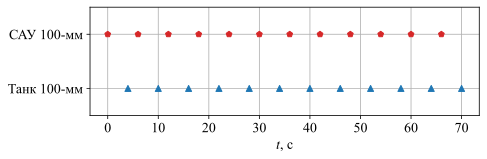

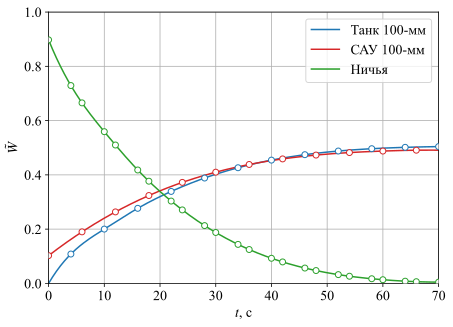

In [139]:
res100 = duel(tank,sau100)
cyclogram(res100,' 100-мм')
dynamic_plot(res100,' 100-мм')

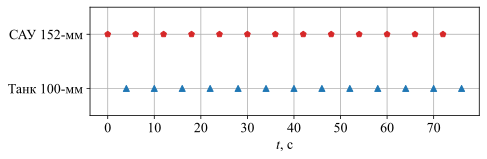

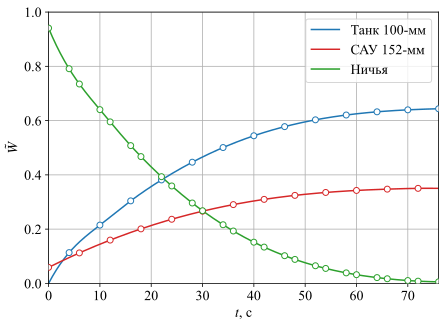

In [138]:
res152 = duel(tank,sau152)
cyclogram(res152,' 152-мм')
dynamic_plot(res152,' 152-мм')